In [5]:
import pandas as pd
import os

# 假设读取 business 类别下的一个或多个excel
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
data_dir = os.path.join(notebook_dir, '../data/raw/business/')
data_dir = os.path.abspath(data_dir)

files = [f for f in os.listdir(data_dir) if f.endswith('.xlsx') or f.endswith('.xls')]

print("发现文件数量：", len(files))

for file in files[:3]:  # 先选几个试试
    path = os.path.join(data_dir, file)
    print(f"正在读取: {file}")
    df = pd.read_excel(path, usecols=['IV_Date', 'IV_Time', 'kVARh_D', 'kWh_D'], na_values=["missing"])
    print(df.head())
    print(df.info())
    print("缺失值统计:\n", df.isnull().sum())
    print("="*40)

发现文件数量： 81
正在读取: E200699PP.xlsx
     IV_Date   IV_Time  kVARh_D  kWh_D
0 2017-06-01  00:00:00    0.360  0.606
1 2017-06-01  00:15:00    0.411  0.651
2 2017-06-01  00:30:00    0.411  0.657
3 2017-06-01  00:45:00    0.408  0.651
4 2017-06-01  01:00:00    0.336  0.555
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105216 entries, 0 to 105215
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   IV_Date  105216 non-null  datetime64[ns]
 1   IV_Time  105216 non-null  object        
 2   kVARh_D  103993 non-null  float64       
 3   kWh_D    104193 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 3.2+ MB
None
缺失值统计:
 IV_Date       0
IV_Time       0
kVARh_D    1223
kWh_D      1023
dtype: int64
正在读取: E151050SPD.xlsx
     IV_Date   IV_Time  kVARh_D  kWh_D
0 2017-06-01  00:00:00    0.036  0.159
1 2017-06-01  00:15:00    0.039  0.159
2 2017-06-01  00:30:00    0.036  0.156
3 2017-06

测试文件读取的效果，按照这样的效果，应该是可以正常读取的。


In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

def handle_missing_one_day(df_day, max_missing=10, method='interpolate', mad_thresh=4):
    """
    对一天的数据（DataFrame）进行缺失值和异常值处理。
    - max_missing: 允许的最大缺失点数，超过则判为无效天
    - method: 缺失处理方式，支持 'interpolate'（插值）或 'mean'（均值填充）
    返回: (补全后的特征np.array, 是否有效, 缺失点数)
    """
    feats = df_day[['kVARh_D', 'kWh_D']].copy()
    # 3-sigma异常值检测
    for col in ['kVARh_D', 'kWh_D']:
        series = feats[col]
        median = series.median()
        mad = np.median(np.abs(series - median))
        if mad == 0 or np.isnan(mad):
            continue  # 跳过MAD为0的列
        modified_z = 0.6745 * (series - median) / mad
        mask = modified_z.abs() > mad_thresh
        feats.loc[mask, col] = np.nan

    missing_count = feats.isnull().sum().sum()
    if missing_count > max_missing:
        return None, False, missing_count
    # 填补缺失
    if method == 'interpolate':
        feats = feats.interpolate(limit_direction='both')
    elif method == 'mean':
        feats = feats.fillna(feats.mean())
    else:
        raise ValueError("Unknown method")
    # 再次判断是否还有残余缺失
    if feats.isnull().any().any():
        return None, False, missing_count
    return feats.to_numpy(), True, missing_count

def plot_day_comparison(raw_df, processed_feats, date):
    # 标记缺失和异常
    is_missing = raw_df.isnull().any(axis=1)
    is_outlier = pd.Series(False, index=raw_df.index)
    z_thresh = 4
    for col in ['kVARh_D', 'kWh_D']:
        series = raw_df[col]
        mean = series.mean()
        std = series.std()
        if std == 0 or np.isnan(std):
            continue
        z_score = (series - mean) / std
        outlier_mask = z_score.abs() > z_thresh  # z_thresh建议与handle_missing_one_day一致
        is_outlier = is_outlier | outlier_mask

    x = range(len(raw_df))
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # 处理前
    axes[0].plot(x, raw_df['kVARh_D'], label='kVARh_D', marker='o')
    axes[0].plot(x, raw_df['kWh_D'], label='kWh_D', marker='o')
    axes[0].set_title(f'{date} no-process')
    axes[0].legend()
    # 处理���
    axes[1].plot(x, processed_feats[:, 0], label='kVARh_D', marker='o', color='tab:blue')
    axes[1].plot(x, processed_feats[:, 1], label='kWh_D', marker='o', color='tab:orange')
    # 标记修复的缺失值
    axes[1].scatter(
        [i for i in x if is_missing.iloc[i]],
        [processed_feats[i, 0] for i in x if is_missing.iloc[i]],
        color='red', label='lack', zorder=5
    )
    axes[1].scatter(
        [i for i in x if is_outlier.iloc[i]],
        [processed_feats[i, 0] for i in x if is_outlier.iloc[i]],
        color='green', label='abnormal', zorder=5
    )
    axes[1].set_title(f'{date} processed')
    axes[1].legend()
    plt.tight_layout()
    plt.show()
# 读取excel
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
data_dir = os.path.join(notebook_dir, '../data/raw/business/')
data_dir = os.path.abspath(data_dir)

df = pd.read_excel(data_dir + '/E200013PP.xlsx', usecols=['IV_Date', 'IV_Time', 'kVARh_D', 'kWh_D'], na_values=["missing"])

missing_day = None
outlier_day = None

for i, (date, group) in enumerate(df.groupby('IV_Date')):
    group = group.sort_values('IV_Time')
    raw_df = group[['kVARh_D', 'kWh_D']].copy()
    # 检查是否有缺失值
    if missing_day is None and raw_df.isnull().any().any():
        feats, valid, miss = handle_missing_one_day(group, max_missing=5, method='interpolate')
        if valid:
            missing_day = (raw_df, feats, date)
    # 检查是否有异常值
    mad_thresh = 4
    is_outlier = False
    for col in ['kVARh_D', 'kWh_D']:
        series = raw_df[col]
        median = series.median()
        mad = np.median(np.abs(series - median))
        if mad == 0 or np.isnan(mad):
            continue
        modified_z = 0.6745 * (series - median) / mad
        if (modified_z.abs() > mad_thresh).any():
            is_outlier = True
    if outlier_day is None and is_outlier:
        feats, valid, miss = handle_missing_one_day(group, max_missing=5, method='interpolate')
        if valid:
            outlier_day = (raw_df, feats, date)
    if missing_day and outlier_day:
        break

# 分别绘制
if missing_day:
    print(f"绘制有缺失值的样例: {missing_day[2]}")
    plot_day_comparison(*missing_day)
if outlier_day:
    print(f"绘制有异常值的样例: {outlier_day[2]}")
    plot_day_comparison(*outlier_day)


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

def find_and_plot_outlier_day(loader, file_path):
    df = pd.read_excel(file_path, usecols=['IV_Date', 'IV_Time', 'kVARh_D', 'kWh_D'], na_values=["missing"])
    for date, group in df.groupby('IV_Date'):
        group = group.sort_values('IV_Time')
        feats = group[['kVARh_D', 'kWh_D']].copy()
        # 记录异常点
        outlier_mask = pd.DataFrame(False, index=feats.index, columns=feats.columns)
        for col in ['kVARh_D', 'kWh_D']:
            series = feats[col]
            median = series.median()
            mad = np.median(np.abs(series - median))
            if mad == 0 or np.isnan(mad):
                continue
            modified_z = 0.6745 * (series - median) / mad
            mask = modified_z.abs() > loader.mad_thresh
            outlier_mask[col] = mask
        if outlier_mask.any().any():
            # 处理后数据
            processed = loader.handle_missing_one_day(group)
            if processed is not None and processed.shape == (96, 2):
                x = range(96)
                plt.figure(figsize=(12, 5))
                for i, col in enumerate(['kVARh_D', 'kWh_D']):
                    plt.subplot(1, 2, i+1)
                    plt.plot(x, feats[col], label='reprocess')
                    plt.plot(x, processed[:, i], label='processed')
                    plt.scatter([j for j in x if outlier_mask[col].iloc[j]],
                                [feats[col].iloc[j] for j in x if outlier_mask[col].iloc[j]],
                                color='red', label='point', zorder=5)
                    plt.title(f'{date} {col}')
                    plt.legend()
                plt.tight_layout()
                plt.show()
                print(f'已绘制 {date} 的异常值对比')
                break  # 只绘制第一个有异常的日样本


class DayDataLoader:
    def __init__(self, max_missing=10, mad_thresh=4, method='interpolate'):
        self.max_missing = max_missing
        self.mad_thresh = mad_thresh
        self.method = method

    def global_outlier_process(self, df):
        # 对全表做MAD异常值检测
        for col in ['kVARh_D', 'kWh_D']:
            series = df[col]
            median = series.median()
            mad = np.median(np.abs(series - median))
            if mad == 0 or np.isnan(mad):
                continue
            modified_z = 0.6745 * (series - median) / mad
            mask = modified_z.abs() > self.mad_thresh
            df.loc[mask, col] = np.nan
        return df

    def handle_missing_one_day(self, df_day):
        feats = df_day[['kVARh_D', 'kWh_D']].copy()
        missing_count = feats.isnull().sum().sum()
        if missing_count > self.max_missing:
            return None
        if self.method == 'interpolate':
            feats = feats.interpolate(limit_direction='both')
        elif self.method == 'mean':
            feats = feats.fillna(feats.mean())
        else:
            raise ValueError("Unknown method")
        if feats.isnull().any().any():
            return None
        return feats.to_numpy()

    def load_and_process(self, file_path):
        df = pd.read_excel(file_path, usecols=['IV_Date', 'IV_Time', 'kVARh_D', 'kWh_D'], na_values=["missing"])
        df = self.global_outlier_process(df)
        samples = []
        for date, group in df.groupby('IV_Date'):
            group = group.sort_values('IV_Time')
            feats = self.handle_missing_one_day(group)
            if feats is not None and feats.shape == (96, 2):
                samples.append(feats)
        if samples:
            return np.stack(samples)
        else:
            return np.empty((0, 96, 2))


loader = DayDataLoader()
data = loader.load_and_process('/Users/yangry1/大三课业/大三下课业/机器学习/大作业文件整理/大作业2/ML2/data/raw/business/E100078PP.xlsx')
print(data.shape)  # 应该是 (n_samples, 96, 2)


输入文件的名称，直接接对整体文件夹下的所有文件进行相关处��。

In [ ]:
import numpy as np
import time

start = time.time()
data = np.load('../data/classfied/business_data.npy', allow_pickle=True)
print(data.shape)
print(f"加载耗时: {time.time() - start:.2f} 秒")

无效样本和重复样本处理的可视化


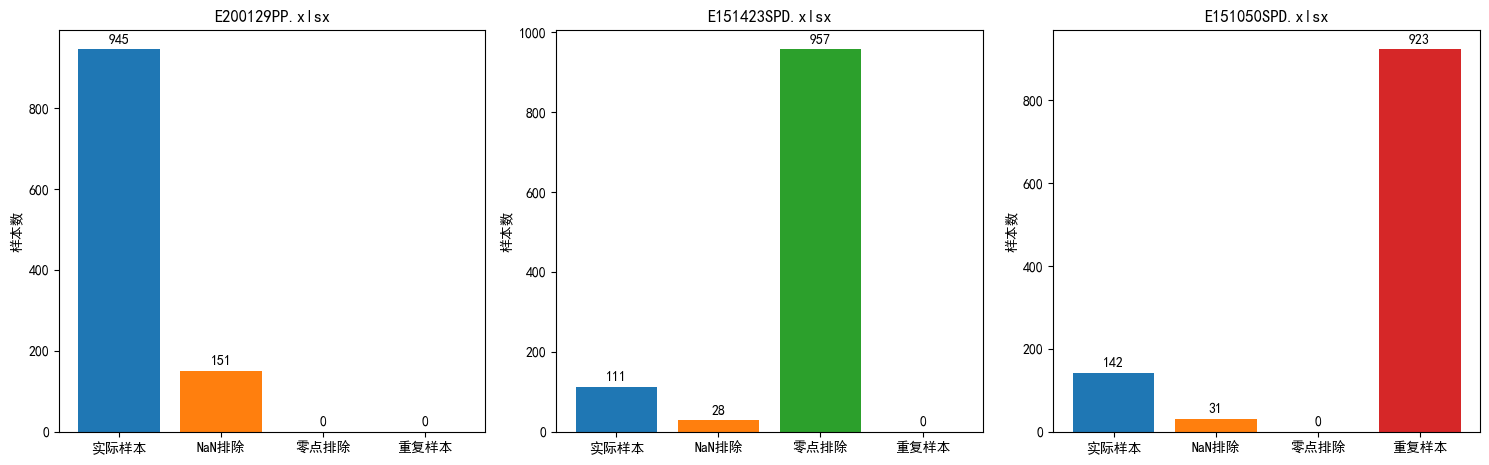

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# 设置matplotlib使用中文字体（假设你已将SimHei.ttf放在notebooks目录下）
font_path = os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), 'SimHei.ttf')
if os.path.exists(font_path):
    matplotlib.font_manager.fontManager.addfont(font_path)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
else:
    print("未找到SimHei.ttf，请将中文字体文件放到notebooks目录下以支持中文显示。")

# 选取极端情况的文件
file_stats = [
    {
        "filename": "E200129PP.xlsx",  # nan极多
        "actual": 945,
        "nan": 151,
        "zero": 0,
        "dup": 0
    },
    {
        "filename": "E151423SPD.xlsx",  # 零点极多
        "actual": 111,
        "nan": 28,
        "zero": 957,
        "dup": 0
    },
    {
        "filename": "E151050SPD.xlsx",  # 重复样本极多
        "actual": 142,
        "nan": 31,
        "zero": 0,
        "dup": 923
    }
]

labels = ['实际样本', 'NaN排除', '零点排除', '重复样本']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig, axes = plt.subplots(1, len(file_stats), figsize=(5 * len(file_stats), 5))
if len(file_stats) == 1:
    axes = [axes]
for ax, stat in zip(axes, file_stats):
    values = [stat['actual'], stat['nan'], stat['zero'], stat['dup']]
    ax.bar(labels, values, color=colors)
    ax.set_title(stat['filename'])
    for i, v in enumerate(values):
        ax.text(i, v + max(values)*0.01, str(v), ha='center', va='bottom', fontsize=10)
    ax.set_ylabel('样本数')
# plt.suptitle('极端文件样本组成可视化')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
